# Predictions: Heart Diseases

Prediction of heart disease given medical informartion. 

## Libraries

In [13]:
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

pd.set_option('display.max_colwidth', None)

In [14]:
MAX_DATASET_SAMPLES = 5000 # Datasets will the capped to this sample_size to keep experiments fast 

## Import Data

In [15]:
datasets = [
    {
        "name": "Heart Attack Prediction Dataset",
        "path": "data/heart.csv",
        "features_numerical": ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak'],
        "features_categorical": ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall'],
        "target": "output",
    },

    {
        "name": "Heart Failure Prediction",
        "path": "data/heart(2).csv",
        "features_numerical": ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak' ],
        "features_categorical": ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope'],
        "target": "HeartDisease",
    },

    {
        "name": "Heart Failure Prediction 2",
        "path": "data/heart_failure_clinical_records_dataset.csv",
        "features_numerical": ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time' ],
        "features_categorical": ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking',],
        "target": "DEATH_EVENT",
    },

    {
        "name": "Cardiovascular Disease Dataset",
        "path": "data/cardio_train.csv",
        "features_numerical": ['age', 'height', 'weight', 'ap_hi', 'ap_lo' ],
        "features_categorical": ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active'],
        "target": "cardio",
    },

    {
        "name": "Indicators of Heart Disease",
        "path": "data/heart_2020_cleaned.csv",
        "features_numerical": ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime',  ],
        "features_categorical": ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer', ],
        "target": "HeartDisease",
    },

]


In [16]:
dataset_path = datasets[0]["path"]
df = pd.read_csv(dataset_path)
df

age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0     63    1   3     145   233    1        0       150     0      2.3    0   
1     37    1   2     130   250    0        1       187     0      3.5    0   
2     41    0   1     130   204    0        0       172     0      1.4    2   
3     56    1   1     120   236    0        1       178     0      0.8    2   
4     57    0   0     120   354    0        1       163     1      0.6    2   
..   ...  ...  ..     ...   ...  ...      ...       ...   ...      ...  ...   
298   57    0   0     140   241    0        1       123     1      0.2    1   
299   45    1   3     110   264    0        1       132     0      1.2    1   
300   68    1   0     144   193    1        1       141     0      3.4    1   
301   57    1   0     130   131    0        1       115     1      1.2    1   
302   57    0   1     130   236    0        0       174     0      0.0    1   

     caa  thall  output  
0      0      1       1  
1      0      2       1  
2      0      2       1  
3      0      2       1  
4      0      2       1  
..   ...    ...     ...  
298    0      3       0  
299    0      3       0  
300    2      3       0  
301    1      3       0  
302    1      2       0  

[303 rows x 14 columns]

## EDA

In [17]:
def describe_dataframe(df:pd.DataFrame)->pd.DataFrame:
    df_describe = df.describe()
    df_describe.loc['dtype'] = df_describe.dtypes
    df_describe.loc['null_count'] = df_describe.isnull().sum()
    print("df.shape:", df.shape)
    return df_describe

describe_dataframe(df)

df.shape: (303, 14)


age       sex        cp      trtbps        chol       fbs  \
count           303.0     303.0     303.0       303.0       303.0     303.0   
mean        54.366337  0.683168  0.966997  131.623762  246.264026  0.148515   
std          9.082101  0.466011  1.032052   17.538143   51.830751  0.356198   
min              29.0       0.0       0.0        94.0       126.0       0.0   
25%              47.5       0.0       0.0       120.0       211.0       0.0   
50%              55.0       1.0       1.0       130.0       240.0       0.0   
75%              61.0       1.0       2.0       140.0       274.5       0.0   
max              77.0       1.0       3.0       200.0       564.0       1.0   
dtype         float64   float64   float64     float64     float64   float64   
null_count          0         0         0           0           0         0   

             restecg    thalachh      exng   oldpeak       slp       caa  \
count          303.0       303.0     303.0     303.0     303.0     303.0   
mean        0.528053  149.646865  0.326733  1.039604   1.39934  0.729373   
std          0.52586   22.905161  0.469794  1.161075  0.616226  1.022606   
min              0.0        71.0       0.0       0.0       0.0       0.0   
25%              0.0       133.5       0.0       0.0       1.0       0.0   
50%              1.0       153.0       0.0       0.8       1.0       0.0   
75%              1.0       166.0       1.0       1.6       2.0       1.0   
max              2.0       202.0       1.0       6.2       2.0       4.0   
dtype        float64     float64   float64   float64   float64   float64   
null_count         0           0         0         0         0         0   

               thall    output  
count          303.0     303.0  
mean        2.313531  0.544554  
std         0.612277  0.498835  
min              0.0       0.0  
25%              2.0       0.0  
50%              2.0       1.0  
75%              3.0       1.0  
max              3.0       1.0  
dtype        float64   float64  
null_count         0         0

## Define Model

In [18]:
# Suppress onehot transformation warnings
import warnings
import re
original_showwarning = warnings.showwarning
def custom_showwarning(message, category, filename, lineno, file=None, line=None):
    if re.match(r"Found unknown categories in columns \[\d+\] during transform\. These unknown categories will be encoded as all zeros", str(message)):
        return  # Suppress the specific warning
    original_showwarning(message, category, filename, lineno, file, line)
warnings.showwarning = custom_showwarning

In [22]:
from sklearn import set_config

# Increase the diagram rendering size
set_config(display='diagram')  # Ensure the pipeline is displayed as a diagram
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 8)  # Adjust the size as needed

In [23]:
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier

def create_pipeline(dataset:dict, classifier:BaseEstimator)->Pipeline:

    features_numerical = dataset["features_numerical"]
    features_categorical = dataset["features_categorical"]
    target = dataset['target']
    features_all = features_numerical+features_categorical

    numerical_pipeline = Pipeline(steps=[
        # ('impute', SimpleImputer(strategy='mean')),
        ('scale', StandardScaler())
    ])
    categorical_pipeline = Pipeline(steps=[
        # ('impute', SimpleImputer(strategy='most_frequent')),
        ('one_hot', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))
    ])
    column_transformer = ColumnTransformer(transformers=[
        ('numerical', numerical_pipeline, features_numerical),
        ('categorical', categorical_pipeline, features_categorical)
    ])
    pipeline = Pipeline(steps=[
        ('preprocessor', column_transformer),
        ('classifier', classifier)
    ])
    
    return pipeline

# pipeline example
create_pipeline(datasets[0], RandomForestClassifier())

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['age', 'trtbps', 'chol',
                                                   'thalachh', 'oldpeak']),
                                                 ('categorical',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['sex', 'cp', 'fbs',
                                                   'restecg', 'exng', 'slp',
                                                   'caa', 'thall'])])),
                ('classifier', RandomForestClassifier())])

In [9]:
from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier


classifiers = [
    SVC(probability=True),
    KNeighborsClassifier(),
    LogisticRegression(n_jobs=-1),
    MLPClassifier(max_iter=1000),
    RandomForestClassifier(n_jobs=-1),
    # ExtraTreesClassifier(n_jobs=-1),
    GradientBoostingClassifier(),
    # paper
    StackingClassifier(n_jobs=-1, estimators=[('lr', LogisticRegression(n_jobs=-1)),    ('rf', RandomForestClassifier(n_jobs=-1))], final_estimator=LogisticRegression()),
    StackingClassifier(n_jobs=-1, estimators=[('svm', SVC(probability=True)),           ('mlp', MLPClassifier(max_iter=1000))], final_estimator=LogisticRegression()),
    StackingClassifier(n_jobs=-1, estimators=[('lr', LogisticRegression(n_jobs=-1)),    ('mlp', MLPClassifier(max_iter=1000))], final_estimator=LogisticRegression()),
    # Arpitha
    StackingClassifier(n_jobs=-1, estimators=[('knn', KNeighborsClassifier(n_jobs=-1)), ('gb', GradientBoostingClassifier())], final_estimator=LogisticRegression()),
    StackingClassifier(n_jobs=-1, estimators=[('lr', LogisticRegression(n_jobs=-1)), ('gb', GradientBoostingClassifier())], final_estimator=LogisticRegression()),
    StackingClassifier(n_jobs=-1, estimators=[('lr', LogisticRegression(n_jobs=-1)), ('knn', KNeighborsClassifier(n_jobs=-1))], final_estimator=LogisticRegression()),

]

In [12]:
create_pipeline(datasets[0], StackingClassifier(n_jobs=-1, estimators=[('lr', LogisticRegression(n_jobs=-1)), ('gb', GradientBoostingClassifier())], final_estimator=LogisticRegression()))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['age', 'trtbps', 'chol',
                                                   'thalachh', 'oldpeak']),
                                                 ('categorical',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['sex', 'cp', 'fbs',
                                                   'restecg', 'exng', 'slp',
                                                   'caa', 'thall'])])),
                ('classifier',
                 StackingClassifier(estimators=[('lr',
                                                 LogisticRegression(n_jobs=-1)),
                                                ('gb',
                                                 GradientBoostingClassifier())],
                                    final_estimator=LogisticRegression(),
                                    n_jobs=-1))])

## Training

In [9]:
results = {}

for dataset in datasets:
    print(40*"##")
    print("Dataset:", dataset["name"])
    dataset_name = dataset["name"]
    results[dataset_name] = {}
    # Load Data
    df = pd.read_csv(dataset['path'])
    if len(df)>MAX_DATASET_SAMPLES: # Use subsample if the data is too large
        df = df.sample(n=MAX_DATASET_SAMPLES, replace=False, random_state=42)

    for classifier in classifiers:
        classifier_name = str(classifier)
        results[dataset_name][classifier_name] = {}
        
        # Crossvalidation
        accuracies = []
        f1_scores = []
        auc_scores = []
        for i in range(10):
            features_numerical = dataset["features_numerical"]
            features_categorical = dataset["features_categorical"]
            target = dataset['target']
            features_all = features_numerical+features_categorical

            # Data Split
            df_train, df_val = train_test_split(df, test_size=0.2)
            X_train = df_train[features_all]
            Y_train = df_train[target]
            X_val = df_val[features_all]
            Y_val = df_val[target]

            # Create pipeline
            pipeline = create_pipeline(dataset, classifier)
            
            # Train and predict
            pipeline.fit(X_train, Y_train)
            y_pred_val = pipeline.predict(X_val)
            y_prob_val = pipeline.predict_proba(X_val)[:, 1]

            # Metrics
            accuracies.append(accuracy_score(Y_val, y_pred_val))
            auc_scores.append(roc_auc_score(Y_val, y_prob_val))
            if (Y_val == 'Yes').any():
                f1_scores.append(f1_score(Y_val, y_pred_val, pos_label='Yes'))
            else:
                f1_scores.append(f1_score(Y_val, y_pred_val))

        accuracy = np.average(accuracies)
        results[dataset_name][classifier_name]["accuracy"] = accuracy
        print(classifier, "average acc:", accuracy)

        f1 = np.average(f1_scores)
        results[dataset_name][classifier_name]["f1"] = f1
        print(classifier, "average f1:", f1)

        auc = np.average(auc_scores)
        results[dataset_name][classifier_name]["auc"] = auc
        print(classifier, "average auc:", auc)

# pprint(results)

################################################################################
Dataset: Heart Attack Prediction Dataset
SVC(probability=True) average acc: 0.8442622950819672
SVC(probability=True) average f1: 0.8506306311858687
SVC(probability=True) average auc: 0.9105259823484323
KNeighborsClassifier() average acc: 0.8147540983606557
KNeighborsClassifier() average f1: 0.8314353555377016
KNeighborsClassifier() average auc: 0.8676398546821241
LogisticRegression(n_jobs=-1) average acc: 0.860655737704918
LogisticRegression(n_jobs=-1) average f1: 0.872378930681377
LogisticRegression(n_jobs=-1) average auc: 0.906584978963725
MLPClassifier(max_iter=1000) average acc: 0.7836065573770492
MLPClassifier(max_iter=1000) average f1: 0.8009086828868824
MLPClassifier(max_iter=1000) average auc: 0.8576749443760502
RandomForestClassifier(n_jobs=-1) average acc: 0.840983606557377
RandomForestClassifier(n_jobs=-1) average f1: 0.8502346087653203
RandomForestClassifier(n_jobs=-1) average auc: 0.9141548794

c:\Users\AsusTUF\anaconda3\envs\heart_disease_predictions\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\AsusTUF\anaconda3\envs\heart_disease_predictions\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\AsusTUF\anaconda3\envs\heart_disease_predictions\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\AsusTUF\anaconda3\envs\heart_disease_predictions\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reac

MLPClassifier(max_iter=1000) average acc: 0.8402173913043477
MLPClassifier(max_iter=1000) average f1: 0.8572124222587633
MLPClassifier(max_iter=1000) average auc: 0.907611682409786
RandomForestClassifier(n_jobs=-1) average acc: 0.8663043478260869
RandomForestClassifier(n_jobs=-1) average f1: 0.8823969811358003
RandomForestClassifier(n_jobs=-1) average auc: 0.9274264826636915
GradientBoostingClassifier() average acc: 0.8766304347826086
GradientBoostingClassifier() average f1: 0.8892118154831966
GradientBoostingClassifier() average auc: 0.9286376131663474
StackingClassifier(estimators=[('lr', LogisticRegression(n_jobs=-1)),
                               ('rf', RandomForestClassifier(n_jobs=-1))],
                   final_estimator=LogisticRegression(), n_jobs=-1) average acc: 0.8728260869565219
StackingClassifier(estimators=[('lr', LogisticRegression(n_jobs=-1)),
                               ('rf', RandomForestClassifier(n_jobs=-1))],
                   final_estimator=LogisticRegress

c:\Users\AsusTUF\anaconda3\envs\heart_disease_predictions\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\AsusTUF\anaconda3\envs\heart_disease_predictions\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\AsusTUF\anaconda3\envs\heart_disease_predictions\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\AsusTUF\anaconda3\envs\heart_disease_predictions\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reac

MLPClassifier(max_iter=1000) average acc: 0.765
MLPClassifier(max_iter=1000) average f1: 0.6384644486667442
MLPClassifier(max_iter=1000) average auc: 0.8264010637252444
RandomForestClassifier(n_jobs=-1) average acc: 0.8316666666666667
RandomForestClassifier(n_jobs=-1) average f1: 0.7116155055689939
RandomForestClassifier(n_jobs=-1) average auc: 0.9127760865320445
GradientBoostingClassifier() average acc: 0.8300000000000001
GradientBoostingClassifier() average f1: 0.7209072196853926
GradientBoostingClassifier() average auc: 0.8714411755885066
StackingClassifier(estimators=[('lr', LogisticRegression(n_jobs=-1)),
                               ('rf', RandomForestClassifier(n_jobs=-1))],
                   final_estimator=LogisticRegression(), n_jobs=-1) average acc: 0.8400000000000001
StackingClassifier(estimators=[('lr', LogisticRegression(n_jobs=-1)),
                               ('rf', RandomForestClassifier(n_jobs=-1))],
                   final_estimator=LogisticRegression(), n_job

In [10]:
def format_results(results_dict:dict)->pd.DataFrame:
    """
    NOTE: Docstring created with ChatGPT, edited by a human
    Converts a nested dictionary of results into a DataFrame with Multi-Index columns.
    
    Parameters:
    - results_dict (dict): Nested dictionary where the first level keys are datasets, 
      the second level keys are models, and the leaf values are dictionaries of metrics.
      
    Returns:
    - pd.DataFrame: A DataFrame with Multi-Index columns for datasets and models, 
      and rows for metrics.
    """
    results_df = pd.DataFrame.from_dict(
        {(dataset, model): metrics for dataset, model_dict in results_dict.items() for model, metrics in model_dict.items()},
        orient="index",
    )

    # Set MultiIndex for the columns
    results_df.index = pd.MultiIndex.from_tuples(results_df.index, names=["Dataset", "Model"])
    results_df.columns.name = "Metric"

    return results_df

display(format_results(results))


Metric                                                                                                                                                                                                                                                  accuracy  \
Dataset                         Model                                                                                                                                                                                                                              
Heart Attack Prediction Dataset SVC(probability=True)                                                                                                                                                                                                   0.844262   
                                KNeighborsClassifier()                                                                                                                                                                                                  0.814754   
                                LogisticRegression(n_jobs=-1)                                                                                                                                                                                           0.860656   
                                MLPClassifier(max_iter=1000)                                                                                                                                                                                            0.783607   
                                RandomForestClassifier(n_jobs=-1)                                                                                                                                                                                       0.840984   
                                GradientBoostingClassifier()                                                                                                                                                                                            0.783607   
                                StackingClassifier(estimators=[('lr', LogisticRegression(n_jobs=-1)),\n                               ('rf', RandomForestClassifier(n_jobs=-1))],\n                   final_estimator=LogisticRegression(), n_jobs=-1)  0.850820   
                                StackingClassifier(estimators=[('svm', SVC(probability=True)),\n                               ('mlp', MLPClassifier(max_iter=1000))],\n                   final_estimator=LogisticRegression(), n_jobs=-1)             0.822951   
                                StackingClassifier(estimators=[('lr', LogisticRegression(n_jobs=-1)),\n                               ('mlp', MLPClassifier(max_iter=1000))],\n                   final_estimator=LogisticRegression(), n_jobs=-1)      0.829508   
                                StackingClassifier(estimators=[('knn', KNeighborsClassifier(n_jobs=-1)),\n                               ('gb', GradientBoostingClassifier())],\n                   final_estimator=LogisticRegression(), n_jobs=-1)    0.822951   
                                StackingClassifier(estimators=[('lr', LogisticRegression(n_jobs=-1)),\n                               ('gb', GradientBoostingClassifier())],\n                   final_estimator=LogisticRegression(), n_jobs=-1)       0.837705   
                                StackingClassifier(estimators=[('lr', LogisticRegression(n_jobs=-1)),\n                               ('knn', KNeighborsClassifier(n_jobs=-1))],\n                   final_estimator=LogisticRegression(), n_jobs=-1)   0.839344   
Heart Failure Prediction        SVC(probability=True)                                                                                                                                                                                                   0.887500   
                                KNeighborsClassifier()                                              

In [11]:
def average_metrics(results):
    # Initialize a dictionary to store metrics by model
    averaged_results = {}
    
    # Iterate through datasets and collect metrics for each model
    for models in results.values():
        for model, metrics in models.items():
            if model not in averaged_results:
                averaged_results[model] = {'accuracy': [], 'f1': [], 'auc': []}
            for metric, value in metrics.items():
                averaged_results[model][metric].append(value)
    
    # Calculate averages for each model
    for model, metrics in averaged_results.items():
        averaged_results[model] = {metric: np.mean(values) for metric, values in metrics.items()}
    
    # Convert the averaged results into a DataFrame
    df = pd.DataFrame.from_dict(averaged_results, orient='index')
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'Model'}, inplace=True)
    
    return df

average_metrics(results)

Model  \
0                                                                                                                                                                                                    SVC(probability=True)   
1                                                                                                                                                                                                   KNeighborsClassifier()   
2                                                                                                                                                                                            LogisticRegression(n_jobs=-1)   
3                                                                                                                                                                                             MLPClassifier(max_iter=1000)   
4                                                                                                                                                                                        RandomForestClassifier(n_jobs=-1)   
5                                                                                                                                                                                             GradientBoostingClassifier()   
6   StackingClassifier(estimators=[('lr', LogisticRegression(n_jobs=-1)),\n                               ('rf', RandomForestClassifier(n_jobs=-1))],\n                   final_estimator=LogisticRegression(), n_jobs=-1)   
7              StackingClassifier(estimators=[('svm', SVC(probability=True)),\n                               ('mlp', MLPClassifier(max_iter=1000))],\n                   final_estimator=LogisticRegression(), n_jobs=-1)   
8       StackingClassifier(estimators=[('lr', LogisticRegression(n_jobs=-1)),\n                               ('mlp', MLPClassifier(max_iter=1000))],\n                   final_estimator=LogisticRegression(), n_jobs=-1)   
9     StackingClassifier(estimators=[('knn', KNeighborsClassifier(n_jobs=-1)),\n                               ('gb', GradientBoostingClassifier())],\n                   final_estimator=LogisticRegression(), n_jobs=-1)   
10       StackingClassifier(estimators=[('lr', LogisticRegression(n_jobs=-1)),\n                               ('gb', GradientBoostingClassifier())],\n                   final_estimator=LogisticRegression(), n_jobs=-1)   
11   StackingClassifier(estimators=[('lr', LogisticRegression(n_jobs=-1)),\n                               ('knn', KNeighborsClassifier(n_jobs=-1))],\n                   final_estimator=LogisticRegression(), n_jobs=-1)   

    accuracy        f1       auc  
0   0.837072  0.633254  0.842365  
1   0.804949  0.600511  0.792651  
2   0.838391  0.665676  0.859880  
3   0.797105  0.646623  0.815956  
4   0.835131  0.643272  0.859824  
5   0.826387  0.649275  0.858595  
6   0.840589  0.662431  0.869425  
7   0.825127  0.624539  0.840424  
8   0.828089  0.642020  0.864700  
9   0.831359  0.645163  0.862659  
10  0.840227  0.665603  0.874761  
11  0.837175  0.653957  0.867164

In [13]:
import json

# Serializing json
json_object = json.dumps(results, indent=4)
 
# Writing to sample.json
with open("results.json", "w") as outfile:
    outfile.write(json_object)

## Graphs

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

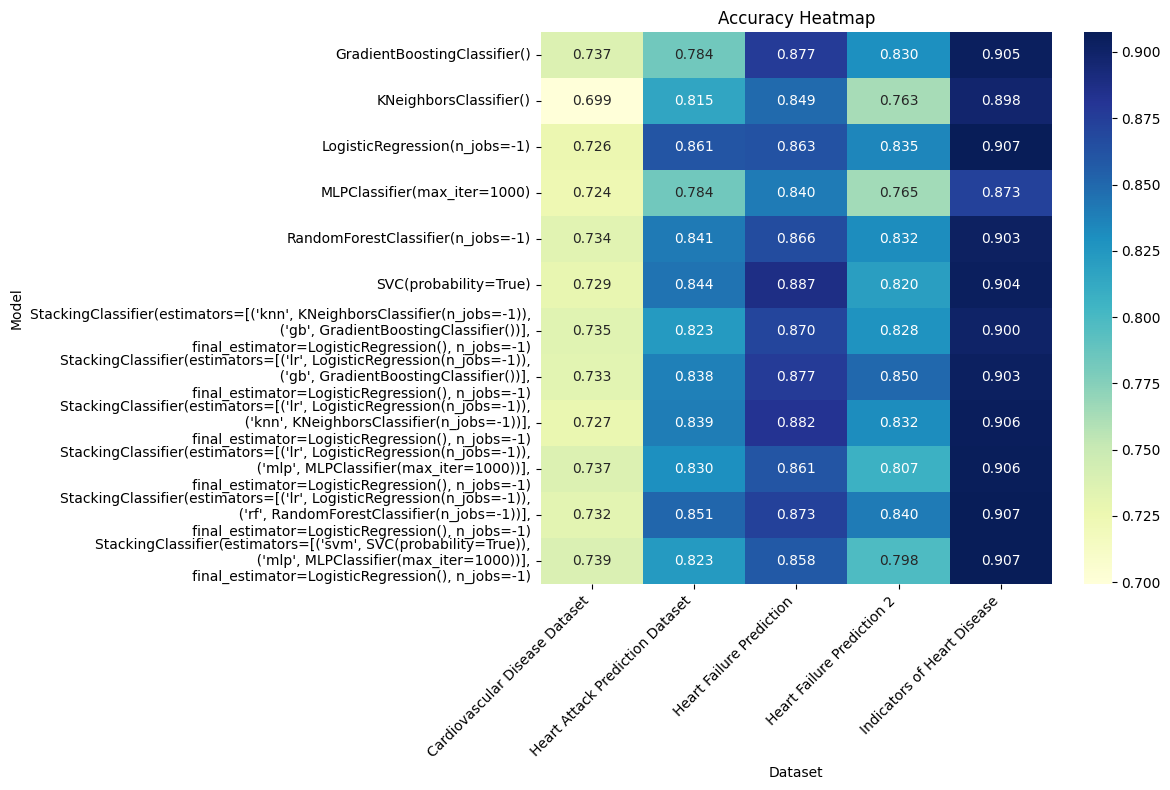

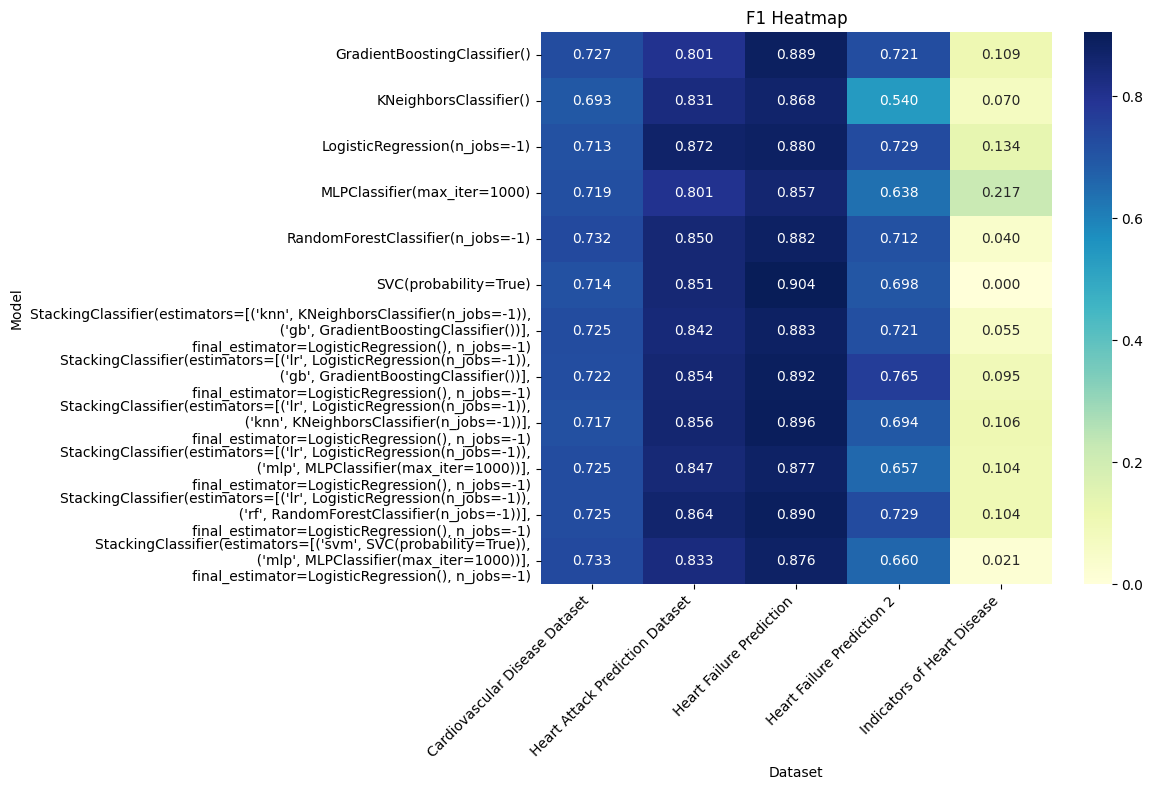

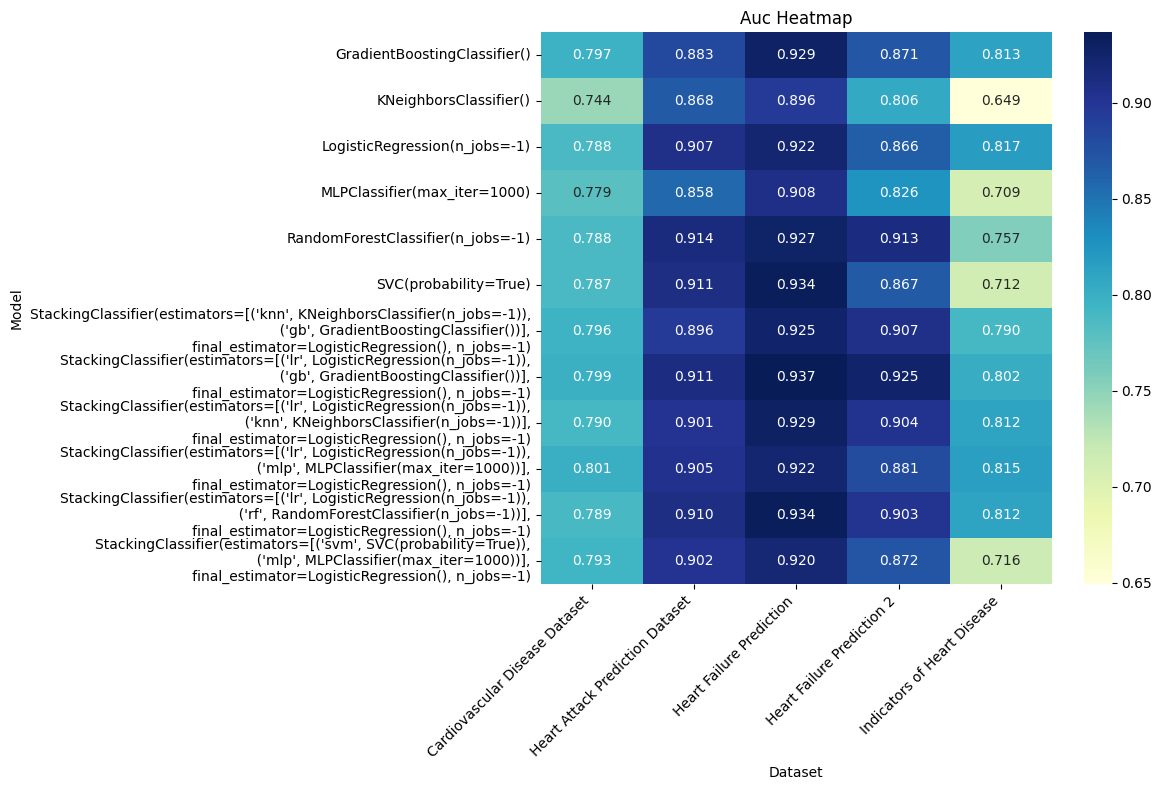

In [16]:
def heatmap_results(results):
    # Create a DataFrame from the dictionary
    data = []
    for dataset, models in results.items():
        for model, metrics in models.items():
            data.append({'Dataset': dataset, 'Model': model, **metrics})
    
    df = pd.DataFrame(data)
    metrics = ['accuracy', 'f1', 'auc']
    
    for metric in metrics:
        pivot_table = df.pivot(index='Model', columns='Dataset', values=metric)
        plt.figure(figsize=(12, 8))
        sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="YlGnBu")
        plt.title(f'{metric.capitalize()} Heatmap')
        plt.ylabel('Model')
        plt.xlabel('Dataset')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

heatmap_results(results)

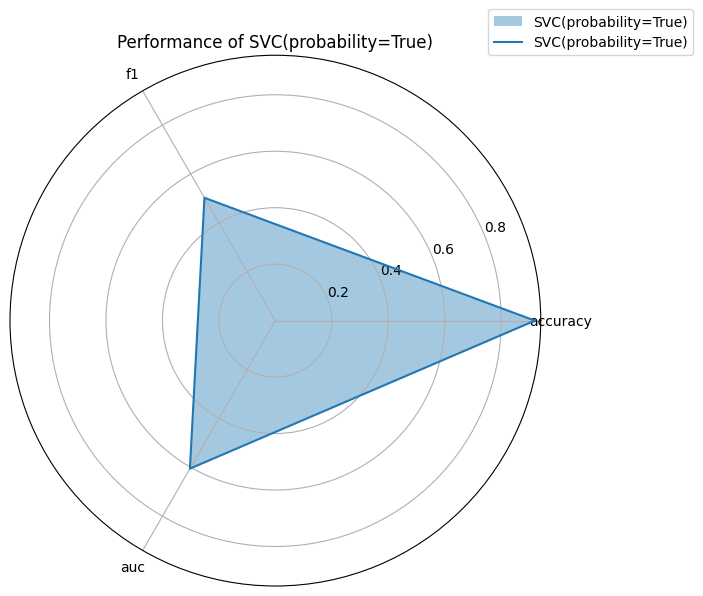

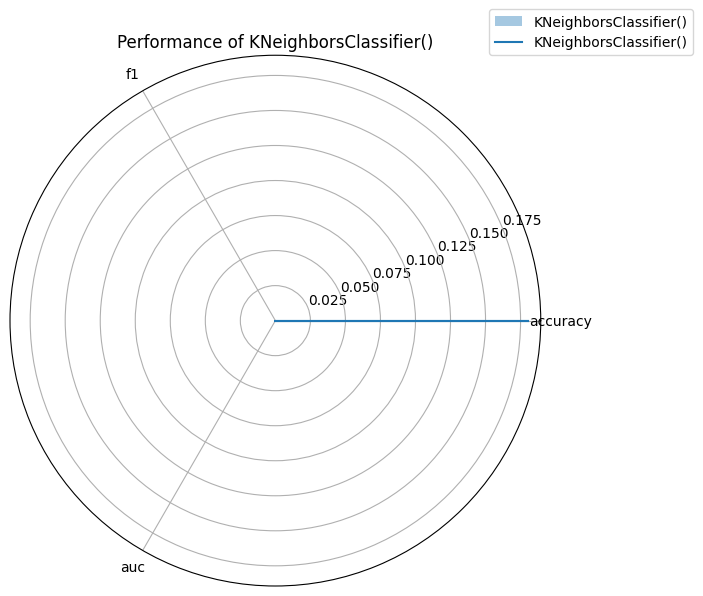

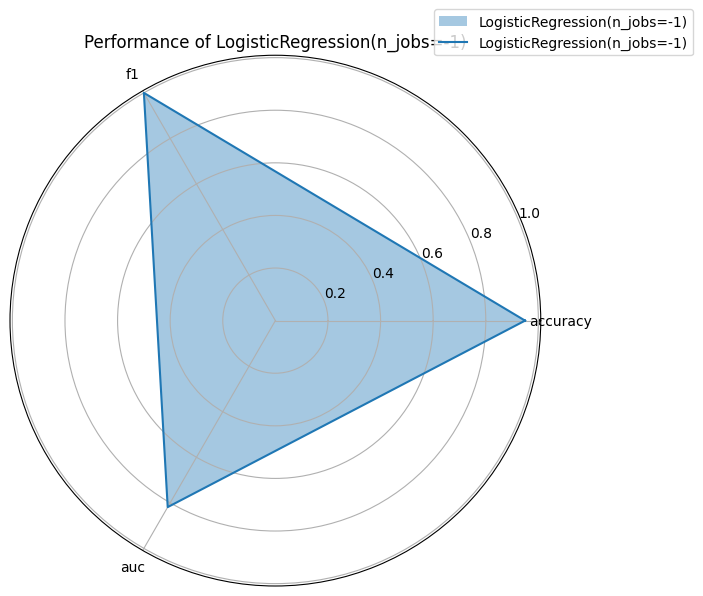

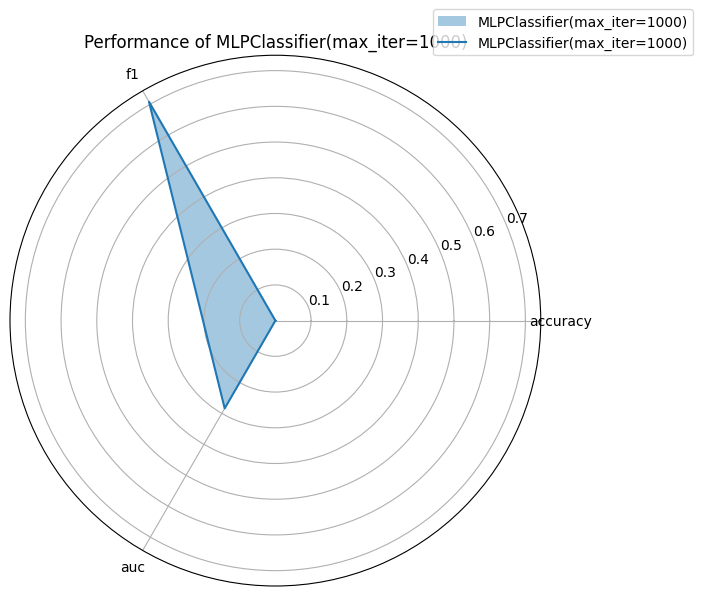

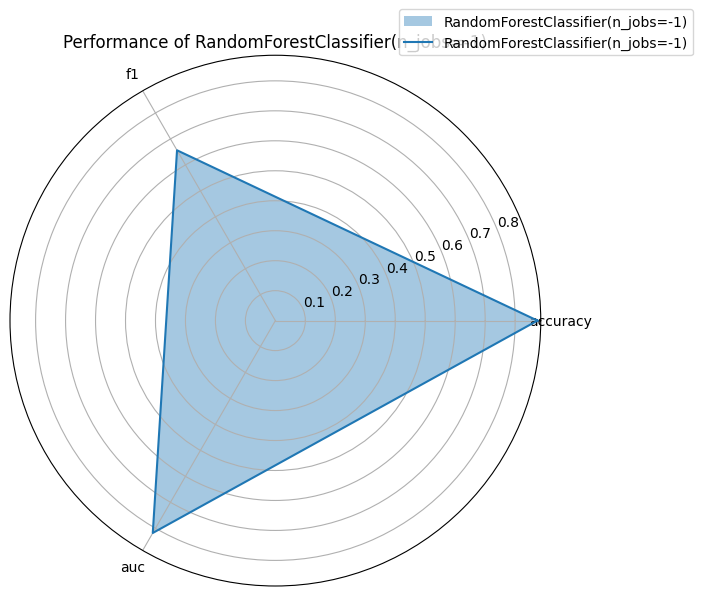

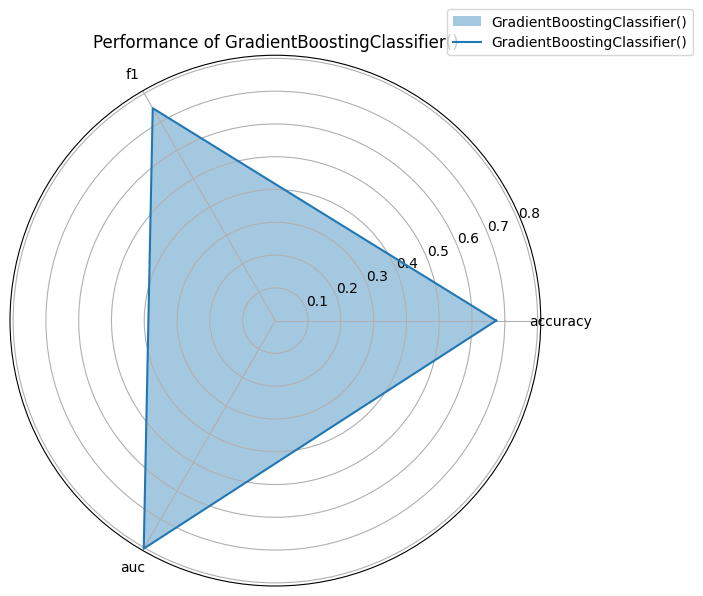

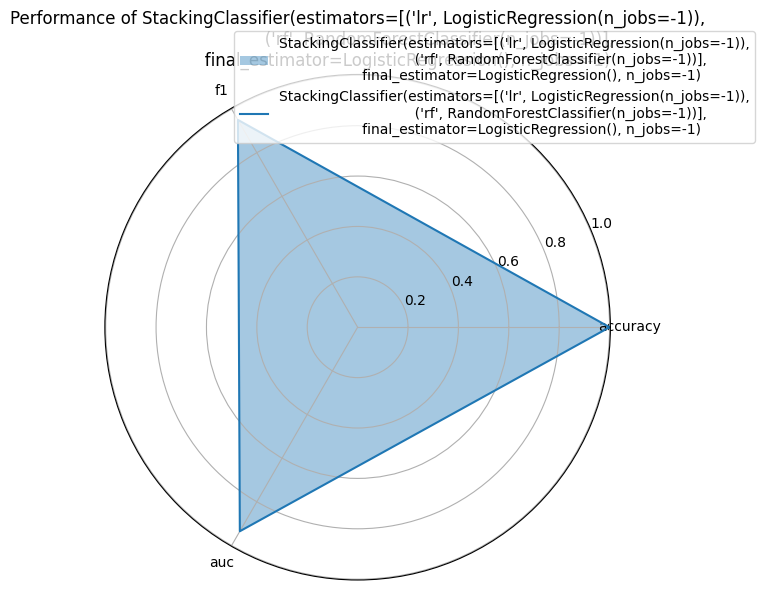

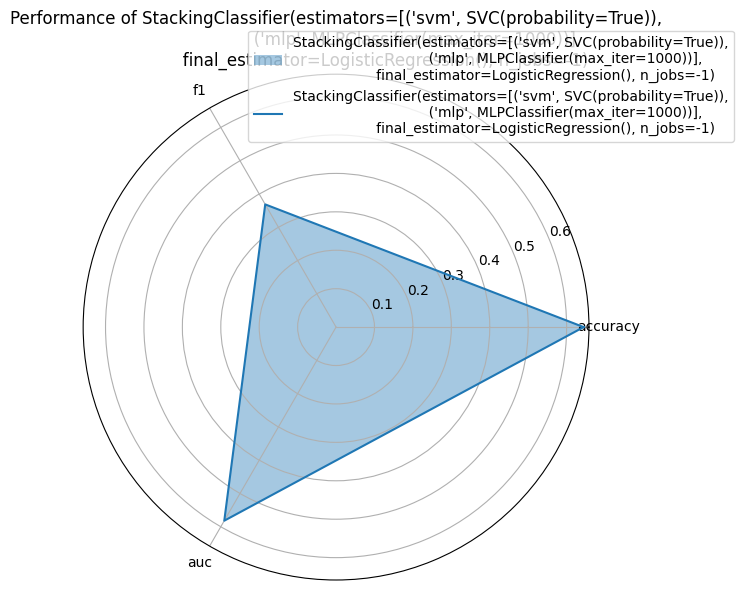

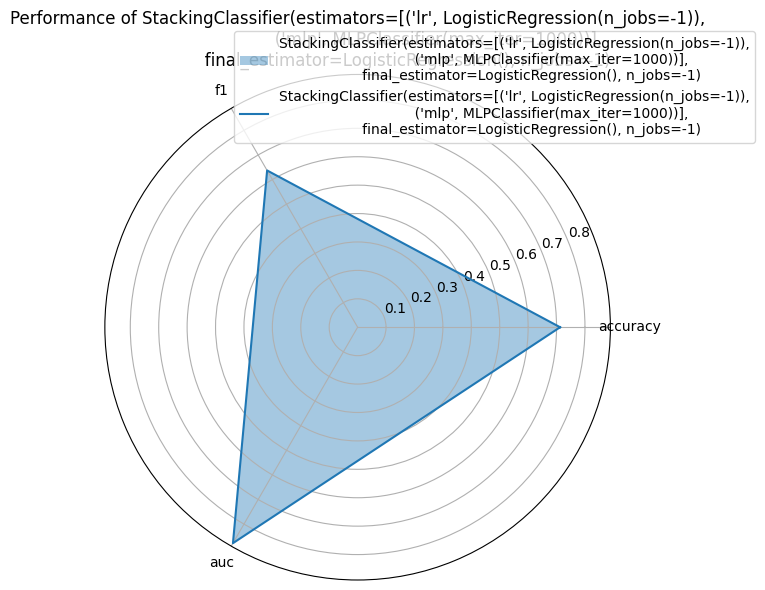

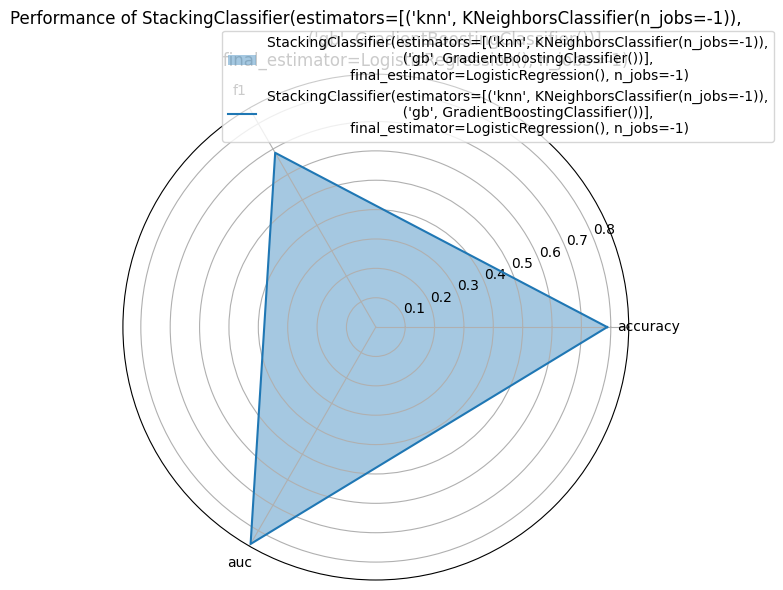

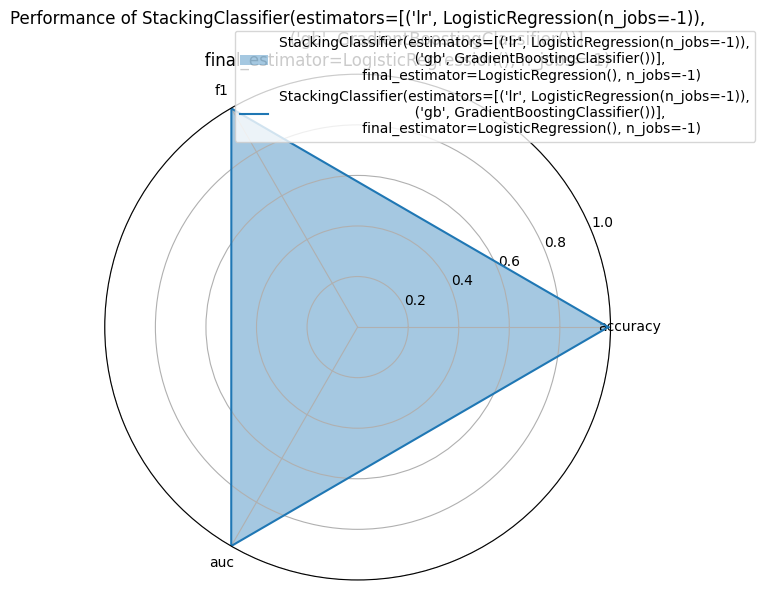

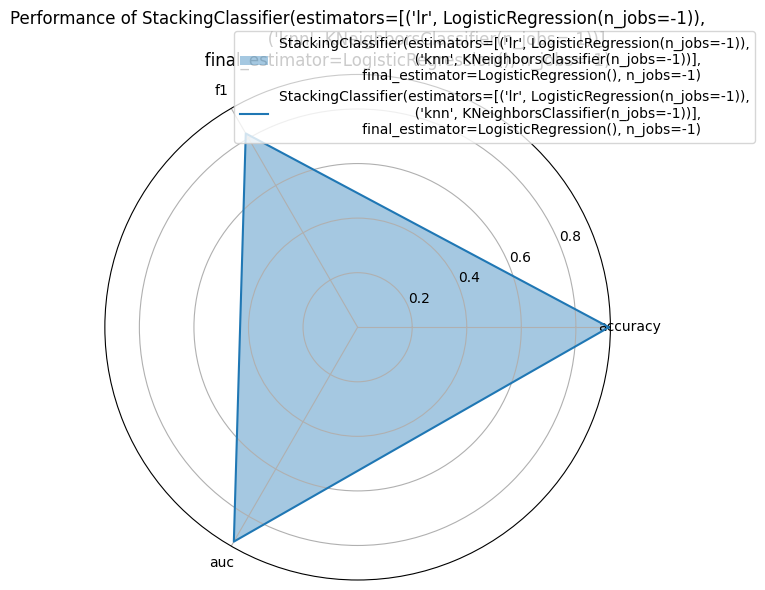

In [17]:
from math import pi

def radar_chart_results(results):
    df = average_metrics(results)
    metrics = ['accuracy', 'f1', 'auc']
    
    # Normalize data for better visualization
    df_norm = df.copy()
    for metric in metrics:
        df_norm[metric] = (df[metric] - df[metric].min()) / (df[metric].max() - df[metric].min())
    
    for _, row in df_norm.iterrows():
        model_name = row['Model']
        values = row[metrics].tolist()
        values += values[:1]  # Close the radar chart
        
        angles = [n / float(len(metrics)) * 2 * pi for n in range(len(metrics))]
        angles += angles[:1]
        
        plt.figure(figsize=(8, 6))
        ax = plt.subplot(111, polar=True)
        ax.fill(angles, values, alpha=0.4, label=model_name)
        ax.plot(angles, values, label=model_name)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(metrics)
        plt.title(f'Performance of {model_name}')
        plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
        plt.tight_layout()
        plt.show()

radar_chart_results(results)

<Figure size 1000x600 with 0 Axes>

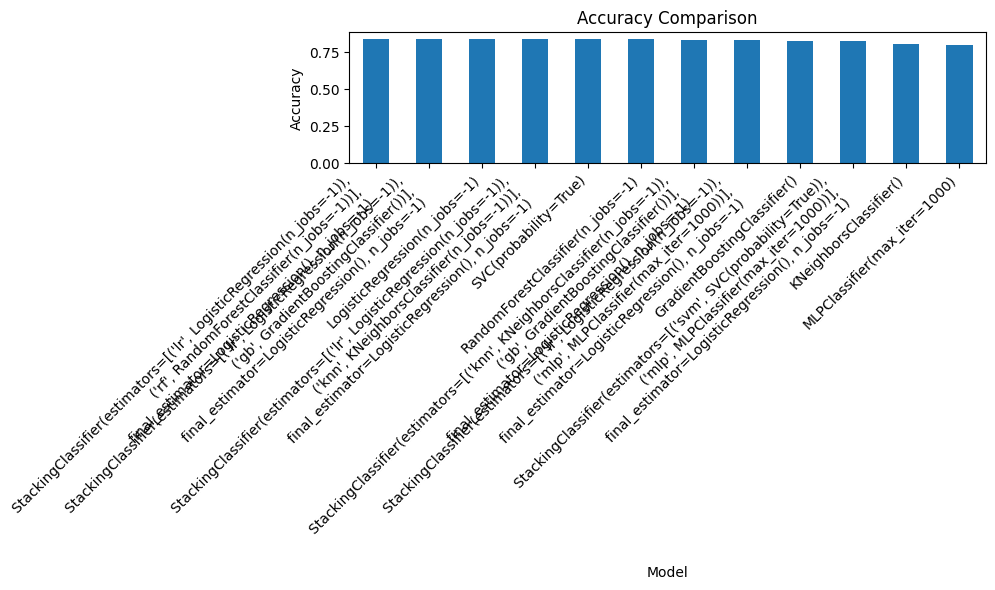

<Figure size 1000x600 with 0 Axes>

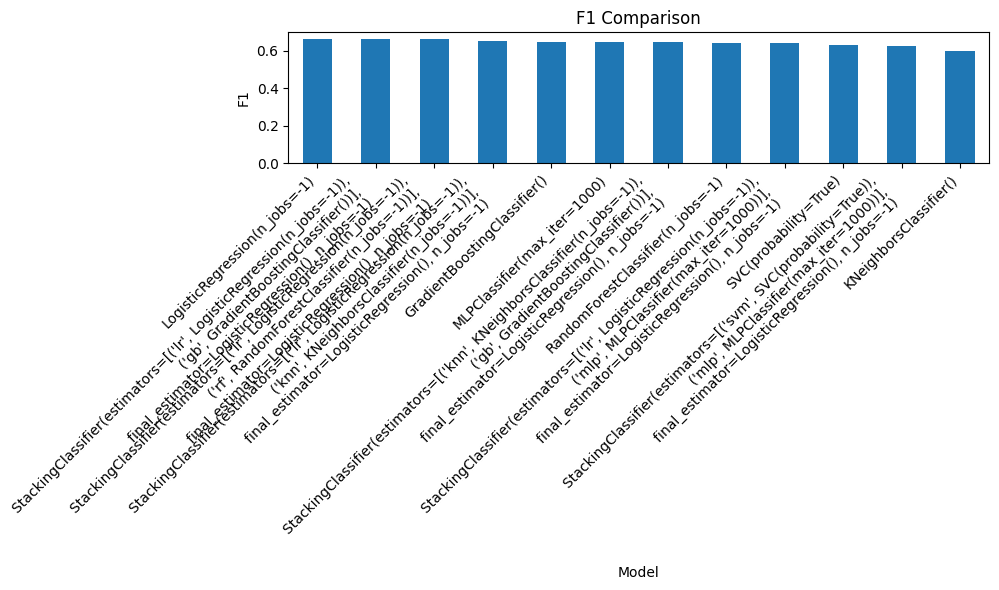

<Figure size 1000x600 with 0 Axes>

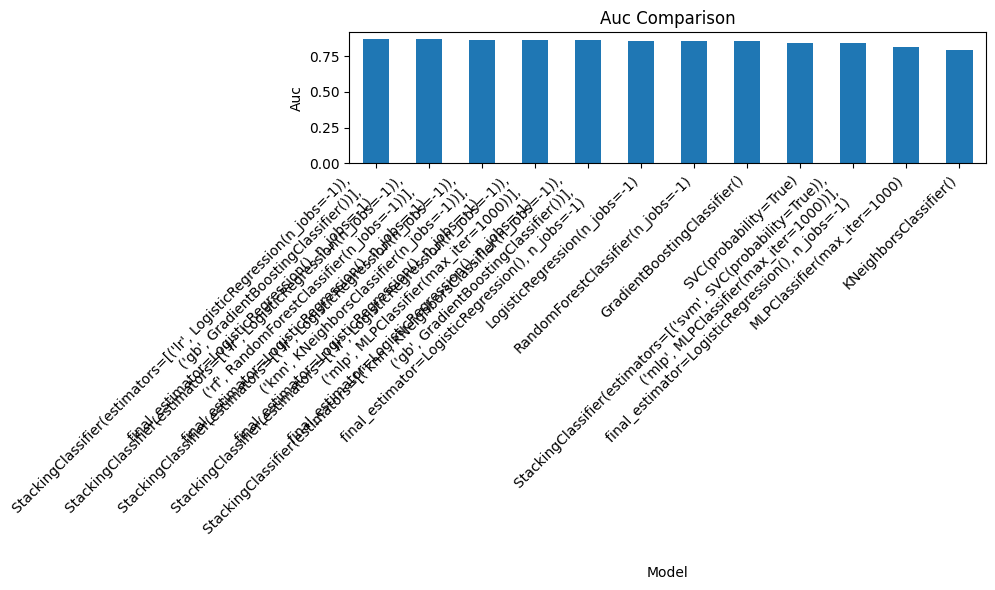

In [18]:
def bar_chart_results(results):
    df = average_metrics(results)
    metrics = ['accuracy', 'f1', 'auc']
    
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        df.sort_values(by=metric, ascending=False).plot(
            x='Model', y=metric, kind='bar', legend=False, figsize=(10, 6), title=f'{metric.capitalize()} Comparison'
        )
        plt.ylabel(metric.capitalize())
        plt.xlabel('Model')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

bar_chart_results(results)


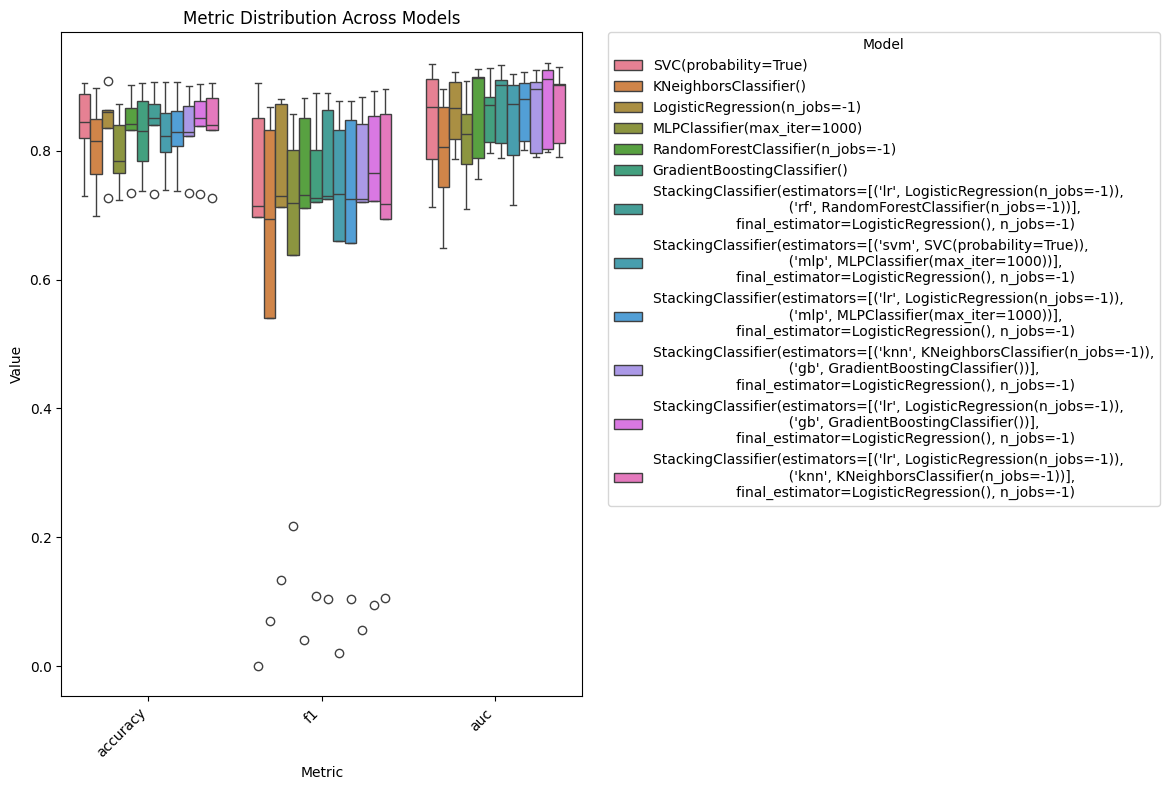

In [22]:
def box_plot_results(results):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import pandas as pd
    
    # Create a DataFrame from the dictionary
    data = []
    for dataset, models in results.items():
        for model, metrics in models.items():
            for metric, value in metrics.items():
                data.append({'Metric': metric, 'Value': value, 'Model': model, 'Dataset': dataset})
    
    df = pd.DataFrame(data)
    
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Metric', y='Value', hue='Model', data=df)
    plt.title('Metric Distribution Across Models')
    plt.ylabel('Value')
    plt.xlabel('Metric')
    plt.xticks(rotation=45, ha='right')
    # Move legend outside
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    plt.show()

box_plot_results(results)

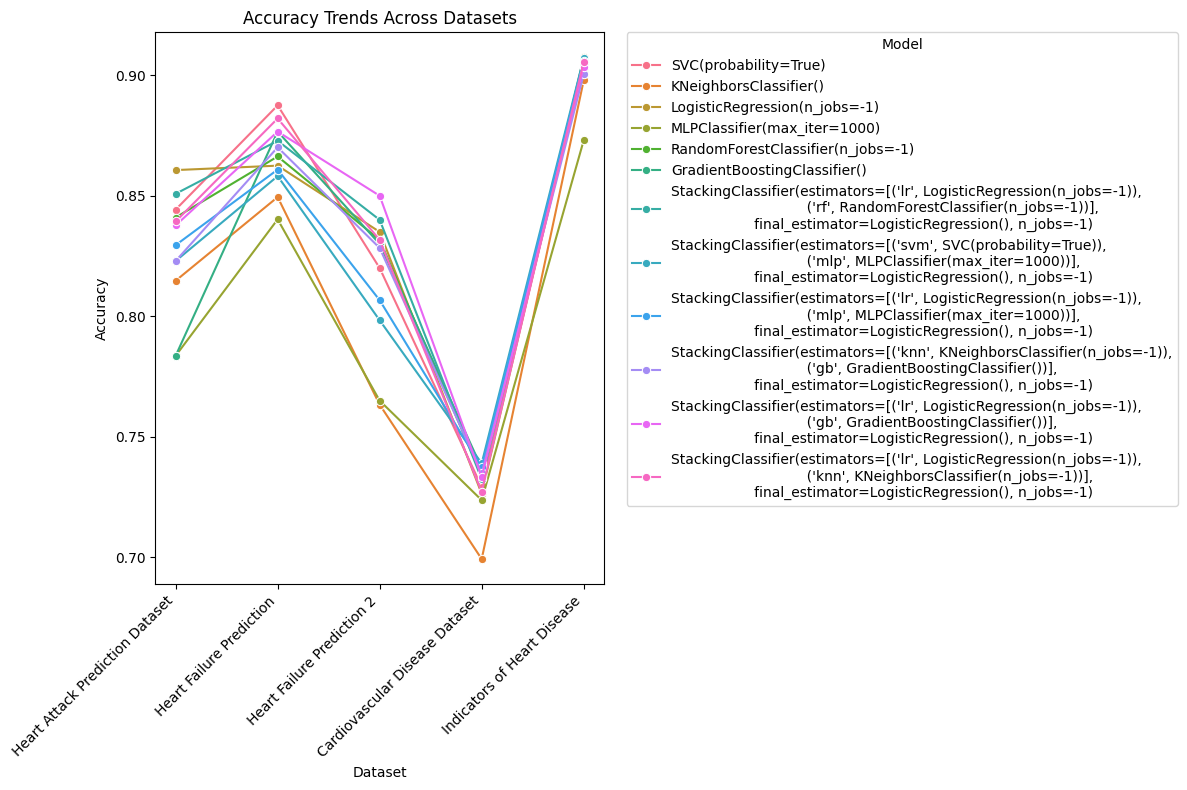

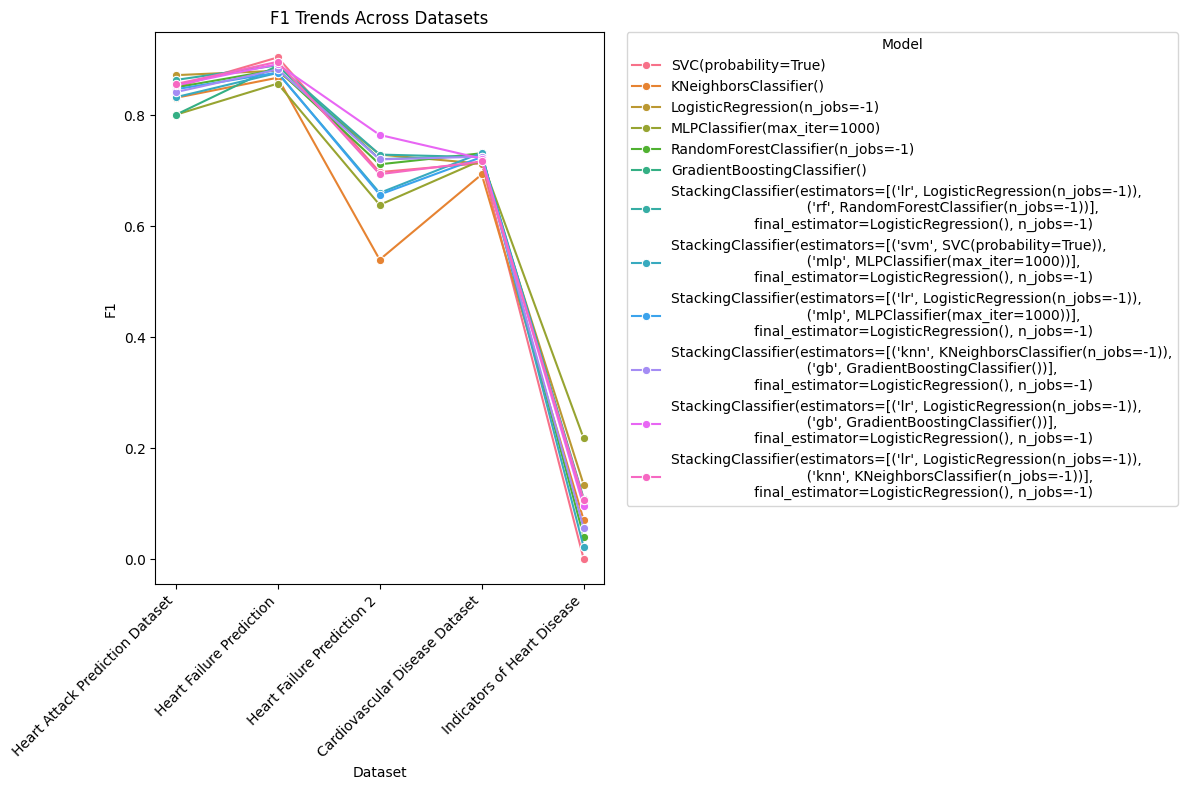

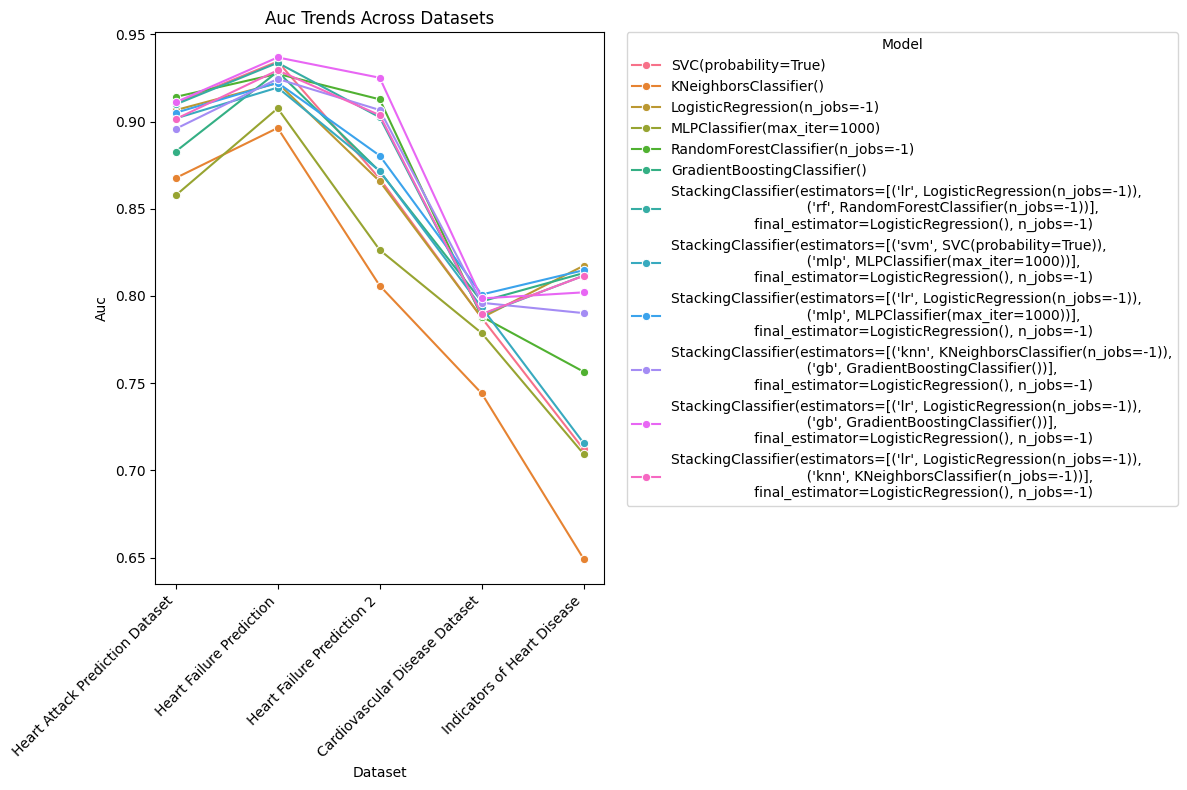

In [21]:
def line_chart_results(results):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import pandas as pd
    
    # Create a DataFrame from the dictionary
    data = []
    for dataset, models in results.items():
        for model, metrics in models.items():
            for metric, value in metrics.items():
                data.append({'Dataset': dataset, 'Metric': metric, 'Value': value, 'Model': model})
    
    df = pd.DataFrame(data)
    metrics = ['accuracy', 'f1', 'auc']
    
    for metric in metrics:
        plt.figure(figsize=(12, 8))
        sns.lineplot(x='Dataset', y='Value', hue='Model', data=df[df['Metric'] == metric], marker='o')
        plt.title(f'{metric.capitalize()} Trends Across Datasets')
        plt.ylabel(metric.capitalize())
        plt.xlabel('Dataset')
        plt.xticks(rotation=45, ha='right')
        # Move legend outside
        plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.tight_layout()
        plt.show()

line_chart_results(results)